In [1]:
import numpy
import scipy.special
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import math
import matplotlib.lines as mlines
from libeng.multiphase import drag_laws
plt.rcParams['figure.figsize'] = 14, 10

In [2]:
def NusseltGunn(Re, Pr, alpha_f):
#* Gunn (1978) correlation 


# Gunn1978 - Function to calculate the Nusselt (or Sherwood) number for the heat 
# (or mass) transfer using the Gunn (1978) correlation for dense flow of spherical particles.
# parameters:
# Re = Reynolds number based on particle diameter and relative velocity
# Pr = Prandtl number based on fluid properties (or Schmidt number for mass transfer)
# alpha_f = fluid volume (void) fraction
#
# returns:
# Nu = Gunn (1978) Nusselt (or Sherwood) number

# references:
# GUNN, D.; Transfer of Heat or Mass to Particles in Fixed and Fluidized Beds, 
# International Journal of Heat and Mass Transfer, volume 21, issue 4, pages 467-476, 1978.
# 

    Nu = (7.0 - 10.0 * alpha_f + 5.0 * alpha_f * alpha_f) * (1.0 + 0.7 * numpy.power(Re, 0.2) * numpy.power(Pr, 0.3333333333)) + \
    (1.33 - 2.4 * alpha_f + 1.2 * alpha_f * alpha_f) * numpy.power(Re, 0.7) * numpy.power(Pr, 0.3333333333)

    return Nu;

def packedBedTrnsMn(a,n):

# calculation of  parameters required for Schumann solution

    nMax = 30

    result = 0
    for i in range(n,nMax+1):
        piProduct = 1
        for j in range(0,n):
            piProduct = piProduct * (i-j)
                 
        result =  result + a**(i-n) * piProduct / (numpy.math.factorial(i))**2
    
    return(result)


def packedBedTrnsMnSum(y, z, nStart):
# calculation of summation bessel function required for Schumann solution
# INPUT
#   t  ...vector containing the dimensionless time
#   z  ...vector containing the dimentionless length
# OUTPUT
#   result    ...vector containing intermediate results of the Schumann solution

    nMax = 30

    a = y * z   
    result = 0
    for n in range (nStart,nMax+1):        
        result = result + z**(n) * packedBedTrnsMn(a,n)
    
    return(result)



def packedBedTrnsTemperatures(t, z):
#classical solution of Schumann
# INPUT
#   t         ...vector containing the dimensionless time
#  z         ...vector containing the dimentionless length
# OUTPUT
#   TgStar    ...vector of dimensionless gas temperature along the bed 
#   TpStar    ...vector of dimensionless particle temperature along the bed 

    TgStar =  1 -  numpy.exp(-z-t) * packedBedTrnsMnSum(t, z, 1) 

    TpStar = 1 - numpy.exp(-z-t) * packedBedTrnsMnSum(t, z, 0)
      
    return([TgStar, TpStar])


        

In [53]:
# fluid properties
rho_g = 1000.00 # [kg/m³] fluid density [kg/m^3]
mu_g = 0.001 # [Pa·s]  dynamic viscosity of fluid 
nu_g = mu_g/rho_g  # [kg/(m.s)] kinematic viscosity of fluid 
c_pg = 3000.0 # [J/kg·K] fluid heat capacity [J/(kg.K)]
T_gi = 500.0 # [K] inlet fluid temperature [K]
T_g0 = 300.0 # [K] initial fluid temperature [K]
k_g = 0.025  # [J/(m.K)] fluid conductivity 
Pr_g = c_pg*mu_g/k_g # [ ] Prandtl number 
print(Pr_g)

#particle properties
d_p = 0.001# [m] particle diameter [m]
rho_p = 5000.0 # [kg/m³] density of particle[kg/m^3]
c_pp = 500.0 # [J/kg·K] particle heat capacity [J/(kg.K)]
T_p0 = T_g0 # [K] initial particle temperature
k_p = 1.0  # [J/(m.K)] particle conductivity 
q_dot = 0.0 # [W/m³]
q_dot_spec = 0.0 #[kJ/(kg.s)] specific heat source 

#Mesh size
l_mesh = 10.0/1000.0 #m
#num_y = num_y + (l_mesh/2.0)
#operating conditions
U_s = 1.0 # [m/s] superficial velocity

epsilon_g = 1-0.5774 # gas volume fraction [dimensionless][ ] 
U = U_s/ epsilon_g   # [m/s] this is the TRUE gas velocity, not superficial [m/s]
#h = 1.0 # [W/m²·K]
time_to_cross_domain = 0.5/(U)

courant = U*0.001/l_mesh
print("time to cross domain = ", time_to_cross_domain)
print("courant = ", courant)

120.0
time to cross domain =  0.2113
courant =  0.236630383341221


In [54]:
Rep = d_p * U / nu_g #Re of particle using TRUE velocity
C_D_Ergun_correlation = drag_laws.Ergun1958(Rep, epsilon_g)
print("Rep = ", Rep)
print("CD = ", C_D_Ergun_correlation)

Re_sup = d_p * U_s / nu_g #Re of particle using superficial velocity
                  
Nu_gunn = NusseltGunn(Re_sup, Pr_g, epsilon_g)
print("epsilon = ", epsilon_g)
print("Pr = ", Pr_g)
print("Re = ", Rep)
#print("Nup = ", Nup)
print("Nup_sup = ", Nu_gunn)
print("Peclet number = ", Rep * Pr_g)

h = k_g * Nu_gunn / d_p;
Biot = h*d_p/k_p
print("Biot = ", Biot )

h_g = (6.0 * h * (1.0 - epsilon_g)) / (epsilon_g * rho_g * c_pg * d_p)
h_p = (6.0 * h) / (rho_p * c_pp * d_p)

hStar = h_g/h_p

print("h_g = ", h_g)
print("h_p = ", h_p)
hpg = h_p + h_g




Rep =  2366.30383341221
CD =  2.4488133333329998
epsilon =  0.4226
Pr =  120.0
Re =  2366.30383341221
Nup_sup =  383.219983716
Peclet number =  283956.4600094652
Biot =  9.5804995929
h_g =  26.1797466396
h_p =  22.993199023


In [55]:
k_values = [100.0, 10.0, 2.50, 1.00]
biot_values = h*d_p/k_values
print(biot_values)

results = dict()
results_standard = dict()
TIME = 0
TEMPERATURE = 1
Y = 2

[ 0.095805    0.95804996  3.83219984  9.58049959]


In [56]:
for k in k_values:
    filename = "improved-k{:.2f}.csv".format(k)
    file = open(filename, mode='r')
    data = file.read()
    file.close()
    
    number_timesteps = data.count('Timestep')
    block_size = data.count('\n') // number_timesteps
    data = data.split('\n')

    temperature = numpy.zeros((number_timesteps, block_size - 3), dtype=numpy.float64)
    time = numpy.zeros((number_timesteps), dtype=numpy.float64)
    y = None
    
    for step in range(number_timesteps):
        block = data[step * block_size : (step + 1) * block_size]
        time[step] = float(block[1].split(',')[1])
        temperature[step] = numpy.loadtxt(block, dtype=numpy.float64, delimiter=',', skiprows=3, usecols=(4,))
        if step == 0:
            y = numpy.loadtxt(block, dtype=numpy.float64, delimiter=',', skiprows=3, usecols=(1,))
    
    results[k] = [time, temperature, y]


file = open("standard.csv", mode='r')
data = file.read()
file.close()
    
number_timesteps = data.count('Timestep')
block_size = data.count('\n') // number_timesteps
data = data.split('\n')

temperature = numpy.zeros((number_timesteps, block_size - 3), dtype=numpy.float64)
time = numpy.zeros((number_timesteps), dtype=numpy.float64)
y = None
    
for step in range(number_timesteps):
    block = data[step * block_size : (step + 1) * block_size]
    time[step] = float(block[1].split(',')[1])
    temperature[step] = numpy.loadtxt(block, dtype=numpy.float64, delimiter=',', skiprows=3, usecols=(4,))
    if step == 0:
        y = numpy.loadtxt(block, dtype=numpy.float64, delimiter=',', skiprows=3, usecols=(1,))
    
results_standard[1] = [time, temperature, y]




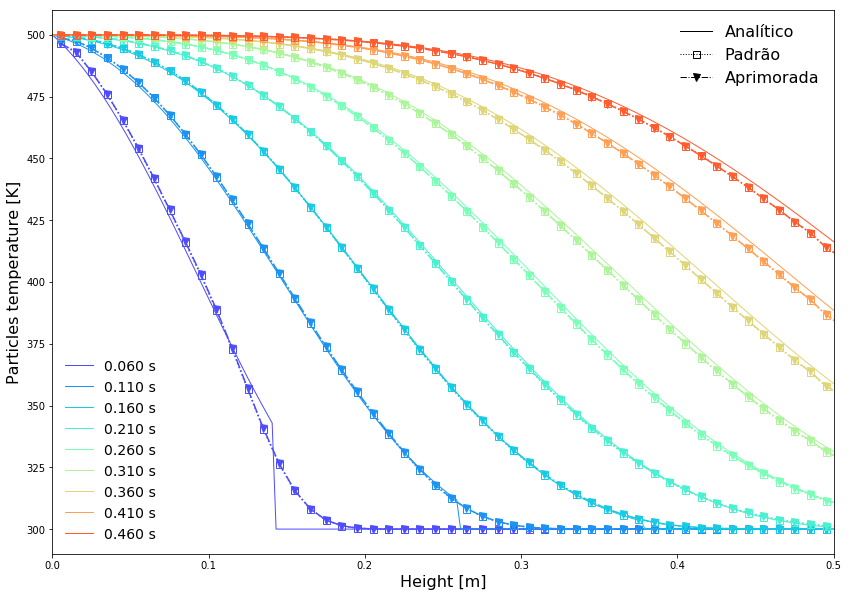

In [106]:
i = 0
inc = 5
marker_list = ["s", "v", "o", "$\u25BC$"]
linestyles = [':', '-.', '--', '-']
cmap = plt.get_cmap('rainbow')
cmap = plt.get_cmap('rainbow')
y = numpy.linspace(0.0, 0.5, 200)
fig, ax = plt.subplots()

for index, time in enumerate(results_standard[1][TIME]):
  
    if(index % inc == 0 and index>0 and time<0.5):
        zStar = (y * h_g / U)
        tStart = time*h_p - (y/U)*h_p
        TgStart = packedBedTrnsTemperatures(tStart,zStar )[0]
        Tg = TgStart*(T_gi-T_g0) + T_g0
        #print(index)
    #print(Tg)
        for t in numpy.where(tStart < 0.0):
            Tg[t] = T_g0
        ax.plot(y, Tg,  ls="-", marker = "None", linewidth=1, color = cmap(index*5),label = "{0:.3f} s".format(time)) 
        ax.plot(results_standard[1][Y]+l_mesh/2, results_standard[1][TEMPERATURE][index],  ls=linestyles[0], markerfacecolor='none',
                marker = marker_list[0], markersize = 7, color = cmap(index*5) )
        ax.plot(results[k_values[0]][Y]+l_mesh/2, results[k_values[0]][TEMPERATURE][index], markersize = 7, 
                ls=linestyles[1], marker = marker_list[1], color = cmap(index*5) )

plt.xlim(0, 0.5) 

custom_lines = [Line2D([0], [0], lw=1, color = 'black', ls="-", marker = "None"),
                Line2D([0], [0], lw=1, color = 'black', ls=linestyles[0], markerfacecolor='none', marker = marker_list[0], markersize = 7),
                Line2D([0], [0], lw=1, color = 'black', ls=linestyles[1],  marker = marker_list[1], markersize = 7)]

lines_legend = plt.legend(custom_lines, ['Analítico', "Padrão","Aprimorada"], fontsize=16, frameon = False)
ax.legend(fontsize=16, loc='lower left', frameon=False)
plt.gca().add_artist(lines_legend)

plt.legend(fontsize=14, loc='lower left', frameon=False)
plt.ylabel('Particles temperature [K]', fontsize=16)
plt.xlabel('Height [m]', fontsize=16)
#plt.savefig('particlesversusposition.png')
plt.show()

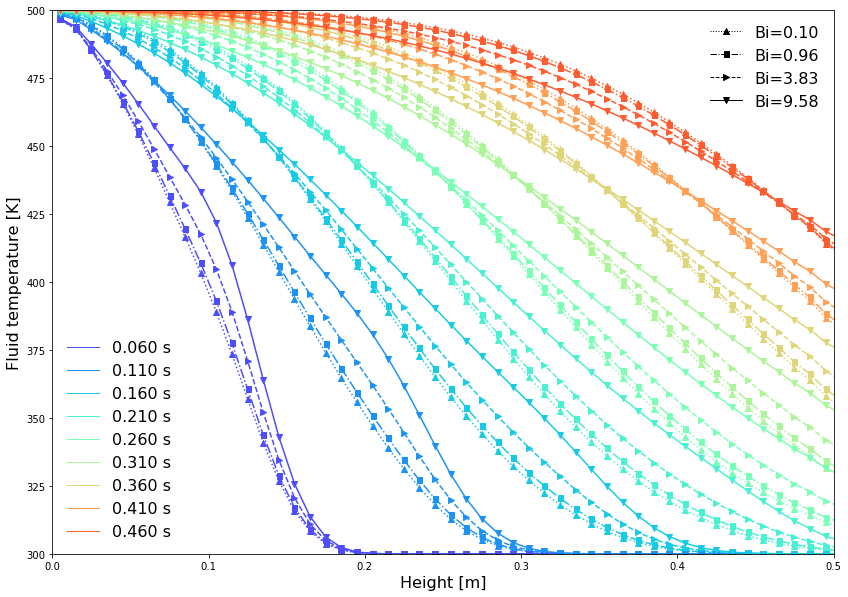

In [105]:
# Fluid temperature x height for each time

marker_list = ["$\u25b2$", "$\u25A0$", "$\u25B6$", "$\u25BC$"]
linestyles = [':', '-.', '--', '-']
cmap = plt.get_cmap('rainbow')
y = numpy.linspace(0.0, 0.5, 200)
analytical_time = results_standard[1][TIME]
#print(analytical_time)

fig, ax = plt.subplots()

# for time in analytical_time[i :50:inc]:
#     zStar = (y * h_g / U)
#     tStart = time*h_p - (y/U)*h_p
#     TgStart = packedBedTrnsTemperatures(tStart,zStar )[0]
#     Tg = TgStart*(T_gi-T_g0) + T_g0
#     #print(time)
#     for index in numpy.where(tStart < 0.0):
#         Tg[index] = T_g0
  
#     #ax.plot(y, Tg, linewidth=1, color = cmap(i*5), label = "{0:.3f} s".format(time))
    
#     i = i + inc

for k in k_values:
    #print(k_values.index(k))
    for index, time in enumerate(results[k][TIME]):
        
        if(index % inc == 0 and index>0 and time<0.5):
            #print(time)
            ax.plot(results[k][Y]+l_mesh/2, results[k][TEMPERATURE][index], marker = marker_list[k_values.index(k)], markersize = 6, 
                     linestyle = linestyles[k_values.index(k)], color = cmap(index*5), )

for index, time in enumerate(results[k][TIME]):
    if(index % inc == 0 and index>0 and time<0.5):
        ax.plot([], [], linewidth=1, color = cmap(index*5), label = "{0:.3f} s".format(time))
            
ax.set_ylim(300, 500)     
ax.set_xlim(0, 0.5) 
ax.set_ylabel('Fluid temperature [K]', fontsize=16)
ax.set_xlabel('Height [m]', fontsize=16)
#ax.annotate('━━ Analytical',xy=(0.01, 425), fontsize=14)

custom_lines = [Line2D([0], [0], lw=1, color = 'black', ls=linestyles[0], marker = marker_list[0]),
                Line2D([0], [0], lw=1, color = 'black', ls=linestyles[1], marker = marker_list[1]),
                Line2D([0], [0], lw=1, color = 'black', ls=linestyles[2], marker = marker_list[2]), 
                Line2D([0], [0], lw=1, color = 'black', ls=linestyles[3], marker = marker_list[3])]

lines_legend = plt.legend(custom_lines, ['Bi={:.2f}'.format(biot_values[0]), 'Bi={:.2f}'.format(biot_values[1]),
                                         'Bi={:.2f}'.format(biot_values[2]), 'Bi={:.2f}'.format(biot_values[3])], fontsize=16, frameon = False)
ax.legend(fontsize=16, loc='lower left', frameon=False)
plt.gca().add_artist(lines_legend)
plt.savefig('gasversusposition.png')
plt.show()


# Fluid temperature x height for each time
